In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append("../")

# choose whether to work on a remote machine
location = "remote"
if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

In [3]:
from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np
import json
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn import model_selection
from scipy.interpolate import interp2d

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sklmetrics
from rasterio.enums import Resampling



import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.plot import show
import rioxarray as rio

from coralshift.utils import directories
from coralshift.processing import spatial_data, baselines
from coralshift.plotting import spatial_plots, model_results


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Data Derivation

In [4]:
def load_and_process_reproducing_xa_das() -> list[xa.DataArray]:
    """
    Load and process xarray data arrays for reproducing metrics.

    Returns
    -------
        list[xa.DataArray]: A list containing the processed xarray data arrays.
    """
    # load in daily sea water potential temp
    thetao_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/thetao.nc")
    
    # load in daily sea water salinity means
    salinity_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/so.nc")

    # load in daily latitudinal and longitudinal currents
    uo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/uo.nc")
    vo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/vo.nc")
    # calculate current magnitude
    current_daily = baselines.calculate_magnitude(uo_daily, vo_daily).rename("current")

    bathymetry = xa.open_dataset(
        directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-00030d.nc").rio.write_crs("EPSG:4326")["bathymetry_A"]

    # Load in ERA5 surface net solar radiation and upscale to climate variable resolution
    solar_radiation = xa.open_dataarray(
        directories.get_era5_data_dir() / "weather_parameters/VAR_surface_net_solar_radiation_LATS_-10_-17_LONS_142_147_YEAR_1993-2020.nc"
        ).rio.write_crs("EPSG:4326")
    # average solar_radiation daily
    solar_radiation_daily = solar_radiation.resample(time="1D").mean(dim="time")

    # Load in ground truth data
    gt_1000m = xa.open_dataarray(directories.get_processed_dir() / "arrays/coral_raster_1000m.nc").rename("gt")

    return [thetao_daily, salinity_daily, current_daily, solar_radiation_daily, bathymetry, gt_1000m]


def resample_list_xa_ds_to_target_resolution_and_merge(xa_das: list[xa.DataArray], target_resolution: float, 
    unit: str = "m", lat_lims: tuple[float] = (-10,-17), lon_lims: tuple[float] = (142,147)) -> dict:
    """
    Resample a list of xarray DataArrays to the target resolution and merge them.

    Parameters
    ----------
        xa_das (list[xa.DataArray]): A list of xarray DataArrays to be resampled and merged.
        target_resolution (float): The target resolution for resampling.
        unit (str, defaults to "m"): The unit of the target resolution.
        interp_method: (str, defaults to "linear") The interpolation method for resampling.

    Returns
    -------
        A dictionary containing the resampled xarray DataArrays merged by their names.
    """
    # TODO: will probably need to save to individual files/folders and combine at test/train time
    # may need to go to target array here
    target_resolution_d = spatial_data.choose_resolution(target_resolution, unit)[1]
    dummy_xa = generate_dummy_xa(target_resolution_d, lat_lims, lon_lims)

    resampled_xa_das_dict = {}
    for xa_da in tqdm(xa_das, desc = "Resampling xarray DataArrays"):

        xa_resampled = upsample_xa_d_to_other(xa_da, dummy_xa, name=xa_da.name)

        resampled_xa_das_dict[xa_da.name] = xa_resampled
    
    return resampled_xa_das_dict
    

def generate_reproducing_metrics(resampled_xa_das_dict: dict) -> xa.Dataset:
    """
    Generate metrics used in Couce et al (2013, 2023) based on the upsampled xarray DataArrays.

    Parameters
    ----------
        resampled_xa_das_dict (dict): A dictionary containing the upsampled xarray DataArrays.

    Returns
    -------
        xa.Dataset: An xarray Dataset containing the reproduced metrics.
    """
    resolution = np.mean(spatial_data.calculate_spatial_resolution([resampled_xa_das_dict.values()][0]))
    save_path = (directories.get_comparison_dir() / f"all_{resolution:.05f}d_comparative").with_suffix(".nc")

    if not save_path.is_file():
        ### TEMPERATURE
        thetao_daily = resampled_xa_das_dict["thetao"]
        # annual average, stdev of annual averages, annual minimum, annual maximum
        thetao_annual_average, _, (thetao_annual_min, thetao_annual_max) = baselines.calc_timeseries_params(thetao_daily, "y", "thetao")
        # monthly average, stdev of monthly averages, monthly minimum, monthly maximum
        thetao_monthly_average, thetao_monthly_stdev, (thetao_monthly_min, thetao_monthly_max) = baselines.calc_timeseries_params(
            thetao_daily, "m", "thetao")
        # annual range (monthly max - monthly min)
        thetao_annual_range = (thetao_annual_max - thetao_annual_min).rename("thetao_annual_range")
        # weekly minimum, weekly maximum
        _, _, (thetao_weekly_min, thetao_weekly_max) = baselines.calc_timeseries_params(thetao_daily, "w", "thetao")
        print("Generated thetao data.")

        ### SALINITY
        salinity_daily = resampled_xa_das_dict["so"]
        # annual average
        salinity_annual_average, _, _ = baselines.calc_timeseries_params(salinity_daily, "y", "salinity")
        # monthly min, monthly max
        _, _, (salinity_monthly_min, salinity_monthly_max) = baselines.calc_timeseries_params(salinity_daily, "m", "salinity")
        print("Generated so data")

        ### CURRENT
        current_daily = resampled_xa_das_dict["current"]
        # annual average
        current_annual_average, _, _ = baselines.calc_timeseries_params(current_daily, "y", "current")
        # monthly min, monthly max
        _, _, (current_monthly_min, current_monthly_max) = baselines.calc_timeseries_params(current_daily, "m", "current")
        print("Generated current data")

        ### BATHYMETRY
        bathymetry_climate_res = resampled_xa_das_dict["bathymetry_A"]
        # bathymetry_climate_res = spatial_data.upsample_xa_d_to_other(bathymetry, thetao_annual_average, name = "bathymetry")
        print("Generated bathymetry data")

        ### ERA5
        solar_daily = resampled_xa_das_dict["ssr"]
        # annual average
        solar_annual_average, _, _ = baselines.calc_timeseries_params(solar_daily, "y", "net_solar")
        # monthly min, monthly max
        _, _, (solar_monthly_min, solar_monthly_max) = baselines.calc_timeseries_params(solar_daily, "m", "net_solar")
        print("Generated solar data")

        ### GT
        gt_climate_res = resampled_xa_das_dict["gt"]
        # upsample to same resolution as climate (1/12 of a degree)
        # gt_climate_res = spatial_data.upsample_xa_d_to_other(gt_1000m, thetao_annual_average, name = "gt")
        print("Generated ground truth data")

        ### MERGE
        merged = xa.merge([thetao_annual_average, thetao_annual_range, thetao_monthly_min, thetao_monthly_max, 
            thetao_monthly_stdev, thetao_weekly_min, thetao_weekly_max, 
            salinity_annual_average, salinity_monthly_min, salinity_monthly_max,
            current_annual_average, current_monthly_min, current_monthly_max,
            solar_annual_average, solar_monthly_min, solar_monthly_max,
            gt_climate_res, bathymetry_climate_res
            ])
        merged.to_netcdf(save_path)
        return merged

    else:
        print(f"{save_path} already exists.")











In [5]:
resolutions = [1, 0.5, 0.25, 1/12, spatial_data.choose_resolution(4000,"m")[1], spatial_data.choose_resolution(1000,"m")[1]]

In [8]:
def generate_varied_data_resolutions(resolutions: list[float], xa_list: list[xa.DataArray]):
    for res in tqdm(resolutions, desc="Generating various resolution xa.Datasets"):
        save_path = (directories.get_comparison_dir() / f"all_{res:.05f}d").with_suffix(".nc")
        if not save_path.exists():
            resampled_xa_das_dict = resample_list_xa_ds_to_target_resolution_and_merge(xa_list, target_resolution=res, unit="m")
            all = xa.merge(list(resampled_xa_das_dict.values()))
            all.to_netcdf(save_path)


In [9]:
generate_varied_data_resolutions(resolutions, xa_list[:2])

Generating various resolution xa.Datasets:   0%|          | 0/6 [00:00<?, ?it/s]

: 

: 

In [202]:
type(list(resampled_xa_das_dict.values()))

list

In [6]:
xa_list = load_and_process_reproducing_xa_das()
# resampled_xa_das_dict = resample_list_xa_ds_to_target_resolution_and_merge(xa_list, target_resolution=4000, unit="m")
# all_4km = generate_reproducing_metrics(resampled_xa_das_dict)

In [196]:
# def resample_train_predict(data_):

def train_test_visualise_roc(all_data: xa.Dataset, name: str = "", runs_n: int = 10, test_fraction: float = 0.25):

    X_train, X_test, y_train, y_test, train_coordinates,test_coordinates, xa_masked = spatial_split_train_test(
        all_data, "gt", split_type="pixel", test_fraction = test_fraction)
    # initialise with random state
    rf = RandomForestRegressor(random_state=42)
    # rf_reg.get_params()
    # rf_random = RandomizedSearchCV(
    #     estimator = rf_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
    #     random_state=RANDOM_STATE, n_jobs = -1)

    rf.fit(X_train, y_train)

    # parameter sweep
    rf_model_fitted = rf

    # save best parameters
    save_dir = file_ops.guarantee_existence(directories.get_datasets_dir() / "model_params")
    save_sklearn_model(rf_model_fitted, save_dir, name)
    # test
    run_outcomes = n_random_runs_preds(
        model = rf_model_fitted, runs_n = 10, xa_ds = all_data, test_fraction = test_fraction)

    return run_outcomes


def train_test_visualise_roc_across_resolutions(resolutions: list[float], runs_n: int = 10, test_fraction: float = 0.25):

    resolutions_dict = {}
    for res in resolutions:
        # load in correct-resolution dataset
        filename = f"couce_params_{res:.05}"
        comparison_file = (directories.get_comparison_dir() / filename).with_suffix(".nc")
        all_data = xa.open_dataset(comparison_file)
        run_outcomes = train_test_visualise_roc(all_data, rf_model, 
            name=f"{filename}_{runs_n}_runs_{test_fraction}_test_fraction", 
            runs_n = runs_n, test_fraction = test_fraction)
        resolutions_dict[res] = run_outcomes


        
        

In [193]:
train_test_visualise_roc_across_resolutions(())

In [222]:
1/0.083

12.048192771084336

In [36]:
### SST (sea water potential temperature)
# load in daily sea water potential temp
thetao_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/thetao.nc")

# annual average, stdev of annual averages, annual minimum, annual maximum
thetao_annual_average, _, (thetao_annual_min, thetao_annual_max) = baselines.calc_timeseries_params(thetao_daily, "y", "thetao")
# monthly average, stdev of monthly averages, monthly minimum, monthly maximum
thetao_monthly_average, thetao_monthly_stdev, (thetao_monthly_min, thetao_monthly_max) = baselines.calc_timeseries_params(
    thetao_daily, "m", "thetao")
# annual range (monthly max - monthly min)
thetao_annual_range = (thetao_annual_max - thetao_annual_min).rename("thetao_annual_range")
# weekly minimum, weekly maximum
_, _, (thetao_weekly_min, thetao_weekly_max) = baselines.calc_timeseries_params(thetao_daily, "w", "thetao")


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/l

In [37]:
### Salinity
# load in daily sea water salinity means
salinity_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/so.nc")

# annual average
salinity_annual_average, _, _ = baselines.calc_timeseries_params(salinity_daily, "y", "salinity")
# monthly min, monthly max
_, _, (salinity_monthly_min, salinity_monthly_max) = baselines.calc_timeseries_params(salinity_daily, "m", "salinity")

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [38]:
### Current speed (dot product of horizontal and vertical)
# load in daily currents (longitudinal and latitudinal)
uo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/uo.nc")
vo_daily = xa.open_dataarray(directories.get_processed_dir() / "arrays/vo.nc")
# calculate current magnitude
current_daily = baselines.calculate_magnitude(uo_daily, vo_daily)

# annual average
current_annual_average, _, _ = baselines.calc_timeseries_params(current_daily, "y", "current")
# monthly min, monthly max
_, _, (current_monthly_min, current_monthly_max) = baselines.calc_timeseries_params(current_daily, "m", "current")

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [42]:
### Light penetration proxy
# Load in bathymetry and scale to climate variable resolution
bathymetry = xa.open_dataset(
    directories.get_bathymetry_datasets_dir() / "bathymetry_A_0-00030d.nc").rio.write_crs("EPSG:4326")["bathymetry_A"]
bathymetry_climate_res = spatial_data.upsample_xa_d_to_other(bathymetry, thetao_annual_average, name = "bathymetry")



In [39]:
# Load in ERA5 surface net solar radiation and upscale to climate variable resolution
solar_radiation = xa.open_dataarray(
    directories.get_era5_data_dir() / "weather_parameters/VAR_surface_net_solar_radiation_LATS_-10_-17_LONS_142_147_YEAR_1993-2020.nc"
    ).rio.write_crs("EPSG:4326")
    
# average solar_radiation daily
solar_radiation_daily = solar_radiation.resample(time="1D").mean(dim="time")
solar_climate_res = spatial_data.upsample_xa_d_to_other(solar_radiation_daily, thetao_annual_average, name = "solar_radiation")

# annual average
solar_annual_average, _, _ = baselines.calc_timeseries_params(solar_climate_res, "y", "net_solar")
# monthly min, monthly max
_, _, (solar_monthly_min, solar_monthly_max) = baselines.calc_timeseries_params(solar_climate_res, "m", "net_solar")


In [40]:
### Load in ground truth data
gt_1000m = xa.open_dataarray(directories.get_processed_dir() / "arrays/coral_raster_1000m.nc")
# upsample to same resolution as climate (1/12 of a degree)
gt_climate_res = spatial_data.upsample_xa_d_to_other(gt_1000m, thetao_annual_average, name = "gt")

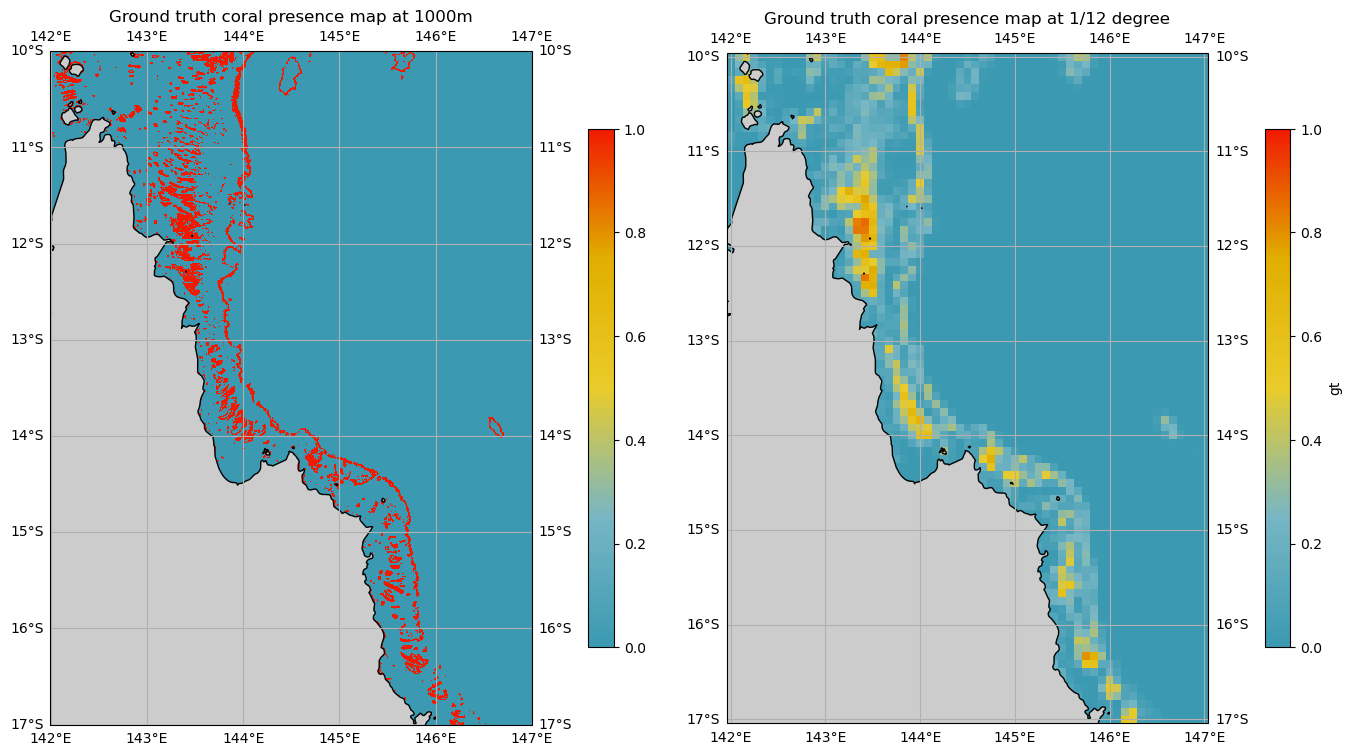

In [41]:
### Display different resolutions
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16,9), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = spatial_plots.plot_spatial(gt_1000m, fax= (fig,ax_left), title="Ground truth coral presence map at 1000m")
ax2 = spatial_plots.plot_spatial(
    gt_climate_res, fax=(fig, ax_right), val_lims = (0,1), title="Ground truth coral presence map at 1/12 degree")

## Baseline Machine Learning Models

In [44]:
# combine data
all_data = xa.merge([thetao_annual_average, thetao_annual_range, thetao_monthly_min, thetao_monthly_max, 
    thetao_monthly_stdev, thetao_weekly_min, thetao_weekly_max, 
    salinity_annual_average, salinity_monthly_min, salinity_monthly_max,
    current_annual_average, current_monthly_min, current_monthly_max,
    bathymetry_climate_res, solar_annual_average, solar_monthly_min, solar_monthly_max,
    gt_climate_res
    ])
    
all_data

<xarray.Dataset>
Dimensions:              (latitude: 85, longitude: 61, time: 28)
Coordinates:
  * latitude             (latitude) float32 -17.0 -16.92 -16.83 ... -10.08 -10.0
  * longitude            (longitude) float32 142.0 142.1 142.2 ... 146.9 147.0
  * time                 (time) datetime64[ns] 1993-01-01 ... 2020-01-01
    spatial_ref          int64 0
    depth                float32 0.494
    band                 int64 1
Data variables: (12/18)
    thetao_y_mean        (latitude, longitude, time) float64 nan nan ... 28.01
    thetao_annual_range  (latitude, longitude) float32 nan nan ... 7.472 7.445
    thetao_m_min         (latitude, longitude) float32 nan nan ... 23.89 23.96
    thetao_m_max         (latitude, longitude) float32 nan nan ... 31.37 31.41
    thetao_m_std         (latitude, longitude) float64 nan nan ... 1.596 1.621
    thetao_w_min         (latitude, longitude) float32 nan nan ... 23.89 23.96
    ...                   ...
    current_m_max        (latitude, longitude) float32 nan nan ... 1.143 1.095
    bathymetry           (latitude, longitude) float32 dask.array<chunksize=(85, 61), meta=np.ndarray>
    net_solar_y_mean     (time, latitude, longitude) float64 dask.array<chunksize=(1, 85, 61), meta=np.ndarray>
    net_solar_m_min      (latitude, longitude) float32 dask.array<chunksize=(85, 61), meta=np.ndarray>
    net_solar_m_max      (latitude, longitude) float32 dask.array<chunksize=(85, 61), meta=np.ndarray>
    gt                   (latitude, longitude) float64 dask.array<chunksize=(85, 61), meta=np.ndarray>

In [48]:
print("latas", len(list(all_data.latitude.values)))
print("lons", len(list(all_data.latitude.values)))

latas 85
lons 85


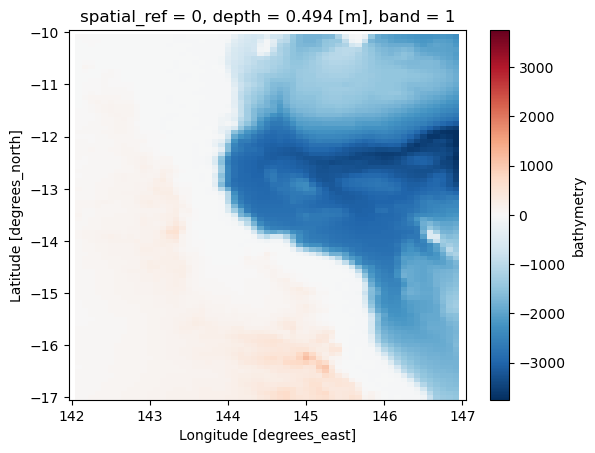

In [57]:
all_data["bathymetry"].plot()

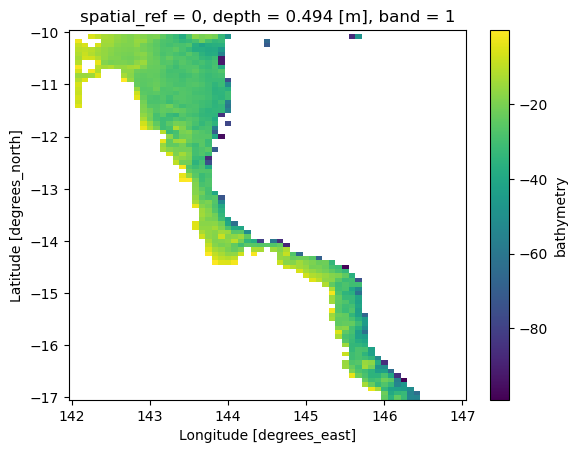

In [89]:
max_depth = -60

xa_ds = all_data.compute()
bath_xa = xa_ds["bathymetry"]

# xa_above = bath_xa.where((bath_xa <= 0) | (bath_xa >= -100), np.nan)
# xa_above = bath_xa.where((bath_xa <= 0) & (bath_xa >= -100), np.nan)
# xa_above = xa_above.where((xa_above >= -100), np.nan)

xs_above = all_data.where((bath_xa <= 0) & (bath_xa >= -100), np.nan)

# xa_above = bath_xa.where((bath_xa <= 0) | (bath_xa >= -100), np.nan)
xa_above.plot()

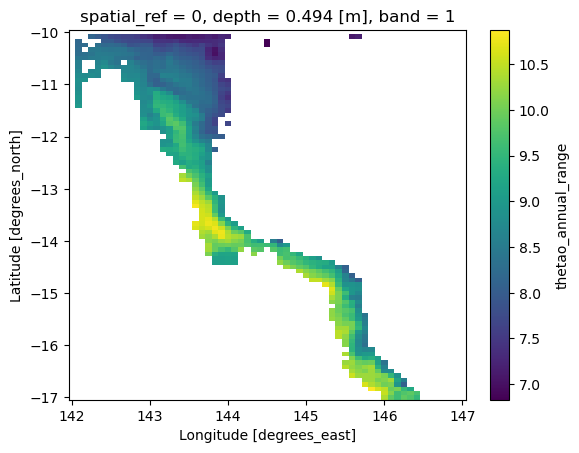

In [92]:
xs_above["thetao_annual_range"].plot()

In [65]:
coords_below_threshold
print("latas", len(list(coords_below_threshold.latitude.values)))
print("lons", len(list(coords_below_threshold.latitude.values)))

latas 81
lons 81


In [ ]:
mask = xa.DataArray(1, dims=xa_ds.dims, coords=xa_ds.coords)
xa_ds = xa_ds.where(mask.isin(coords_below_threshold), other=float("nan"))

In [66]:
test_df = all_data.to_dataframe()
# test_df = test_df.dropna(subset=subset, how="any",axis=0)
test_df = test_df.fillna(0)

test_df.describe()

,spatial_ref,thetao_y_mean,depth,band,thetao_annual_range,thetao_m_min,thetao_m_max,thetao_m_std,thetao_w_min,thetao_w_max,salinity_y_mean,salinity_m_min,salinity_m_max,current_y_mean,current_m_min,current_m_max,gt
count,145180.0,145180.000000,145180.000000,145180.0,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000,145180.000000
mean,0.0,17.243649,0.494025,1.0,4.868803,14.807341,19.676146,1.065930,14.807341,19.676146,22.011253,20.683403,22.489204,0.157386,0.001724,0.596281,0.037064
std,0.0,13.223847,0.000000,0.0,3.816200,11.364732,15.086619,0.843691,11.364732,15.086619,16.873358,15.864980,17.239174,0.139635,0.001913,0.524662,0.106203
min,0.0,0.000000,0.494025,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.494025,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,27.018605,0.494025,1.0,6.894497,23.051577,30.925352,1.509679,23.051577,30.925352,34.777422,32.276375,35.598316,0.189403,0.001365,0.669836,0.000000
75%,0.0,27.442490,0.494025,1.0,7.705313,23.918058,31.128971,1.623355,23.918058,31.128971,34.998985,33.089695,35.671558,0.253246,0.002730,1.006590,0.000000
max,0.0,30.070589,0.494025,1.0,10.921476,24.348736,33.087528,2.660986,24.348736,33.087528,36.169010,34.148685,36.393322,1.009541,0.012583,2.180845,0.865673


In [67]:
# drop unnecessary columns
features_df = pd.get_dummies(test_df).drop(["spatial_ref","band","depth","gt"], axis=1)
features_df

thetao_y_mean  thetao_annual_range   
latitude longitude time                                             
-17.0    142.0     1993-01-01       0.000000             0.000000  \
                   1994-01-01       0.000000             0.000000   
                   1995-01-01       0.000000             0.000000   
                   1996-01-01       0.000000             0.000000   
                   1997-01-01       0.000000             0.000000   
...                                      ...                  ...   
-10.0    147.0     2016-01-01      28.396192             7.445293   
                   2017-01-01      27.954790             7.445293   
                   2018-01-01      27.523144             7.445293   
                   2019-01-01      27.303171             7.445293   
                   2020-01-01      28.005788             7.445293   

                               thetao_m_min  thetao_m_max  thetao_m_std   
latitude longitude time                                                   
-17.0    142.0     1993-01-01      0.000000      0.000000      0.000000  \
                   1994-01-01      0.000000      0.000000      0.000000   
                   1995-01-01      0.000000      0.000000      0.000000   
                   1996-01-01      0.000000      0.000000      0.000000   
                   1997-01-01      0.000000      0.000000      0.000000   
...                                     ...           ...           ...   
-10.0    147.0     2016-01-01     23.964935     31.410229      1.620939   
                   2017-01-01     23.964935     31.410229      1.620939   
                   2018-01-01     23.964935     31.410229      1.620939   
                   2019-01-01     23.964935     31.410229      1.620939   
                   2020-01-01     23.964935     31.410229      1.620939   

                               thetao_w_min  thetao_w_max  salinity_y_mean   
latitude longitude time                                                      
-17.0    142.0     1993-01-01      0.000000      0.000000         0.000000  \
                   1994-01-01      0.000000      0.000000         0.000000   
                   1995-01-01      0.000000      0.000000         0.000000   
                   1996-01-01      0.000000      0.000000         0.000000   
                   1997-01-01      0.000000      0.000000         0.000000   
...                                     ...           ...              ...   
-10.0    147.0     2016-01-01     23.964935     31.410229        34.865664   
                   2017-01-01     23.964935     31.410229        34.322036   
                   2018-01-01     23.964935     31.410229        34.560301   
                   2019-01-01     23.964935     31.410229        34.600538   
                   2020-01-01     23.964935     31.410229        34.557876   

                               salinity_m_min  salinity_m_max  current_y_mean   
latitude longitude time                                                         
-17.0    142.0     1993-01-01        0.000000        0.000000        0.000000  \
                   1994-01-01        0.000000        0.000000        0.000000   
                   1995-01-01        0.000000        0.000000        0.000000   
                   1996-01-01        0.000000        0.000000        0.000000   
                   1997-01-01        0.000000        0.000000        0.000000   
...                                       ...             ...             ...   
-10.0    147.0     2016-01-01       30.642109       35.566273        0.303961   
                   2017-01-01       30.642109       35.566273        0.345949   
                   2018-01-01       30.642109       35.566273        0.277400   
                   2019-01-01       30.642109       35.566273        0.263077   
                   2020-01-01       30.642109       35.566273        0.366986   

                               current_m_min  current_m_max  
latitude longitude time   

In [68]:
target_df = test_df["gt"]
target_df

latitude  longitude  time      
-17.0     142.0      1993-01-01    0.0
                     1994-01-01    0.0
                     1995-01-01    0.0
                     1996-01-01    0.0
                     1997-01-01    0.0
                                  ... 
-10.0     147.0      2016-01-01    0.0
                     2017-01-01    0.0
                     2018-01-01    0.0
                     2019-01-01    0.0
                     2020-01-01    0.0
Name: gt, Length: 145180, dtype: float64

In [95]:
l = []

any(l)


False

In [486]:
all_data["bathymetry"].compute()

<xarray.DataArray 'bathymetry' (latitude: 85, longitude: 61)>
array([[           nan,  4.7552986e+01,  5.3279625e+01, ...,
        -1.4297302e+03, -1.4864319e+03,            nan],
       [           nan,  4.3889202e+01,  4.9429531e+01, ...,
        -1.4897535e+03, -1.5242222e+03,            nan],
       [           nan,  3.9498402e+01,  4.4572536e+01, ...,
        -1.5585811e+03, -1.5714905e+03,            nan],
       ...,
       [           nan, -2.5100784e+00,  1.1239823e+01, ...,
        -2.1013025e+03, -2.2253467e+03,            nan],
       [           nan,  6.1723530e-01,  1.2572575e+01, ...,
        -2.2171638e+03, -2.2938840e+03,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * longitude    (longitude) float32 142.0 142.1 142.2 ... 146.8 146.9 147.0
    spatial_ref  int64 0
    depth        float32 0.494
    band         int64 1
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [174]:
def find_index_pair(xa_da, lat, lon, lat_spacing, lon_spacing):
    # Get the latitude and longitude spacing

    lat_values = list(xa_da.latitude.values)
    lon_values = list(xa_da.longitude.values)

    lat_index = np.where(np.isclose(lat_values, lat))[0][0]
    lon_index = np.where(np.isclose(lon_values, lon))[0][0]

    return lat_index, lon_index


def select_rows_by_coordinates(dataframe: pd.DataFrame, coordinates: list) -> pd.DataFrame:
    """
    Select rows from a Pandas DataFrame based on matching latitude and longitude values.

    Parameters
    ----------
        dataframe (pd.DataFrame): The Pandas DataFrame.
        coordinates (list): List of tuples containing latitude and longitude values.

    Returns
    -------
        pd.DataFrame: The selected subset of the DataFrame.
    """
    indices = list(zip(dataframe.index.get_level_values(0), dataframe.index.get_level_values(1)))
    row_inds = [index for index, item in enumerate(indices) if item in coordinates]

    return dataframe.iloc[row_inds]


def generate_coordinate_pairs(xa_da: xa.DataArray, split_ratio: float, random_seed: int = None) -> tuple[list, list]:
    """
    Generate two lists of coordinate pairs from an xarray DataArray in the specified split ratio.

    Parameters
    ----------
        xa_da (xa.DataArray): The xarray DataArray.
        split_ratio (float): The split ratio for dividing the coordinates.

    Returns
    -------
        tuple[list, list]: A tuple containing the two lists of coordinate pairs.
    """
    # TODO: could omit nans from test/train
    if random_seed:
        # set random seed
        np.random.seed(random_seed)

    spatial_coords = xa_da.drop_dims("time").drop(["spatial_ref","depth","band"]).coords

    # Get the total number of samples
    num_samples = len(spatial_coords["latitude"]) * len(spatial_coords["longitude"])

    # Calculate the split sizes
    test_size = int(num_samples * split_ratio)
    train_size = num_samples - test_size

    # Split the coordinates into two lists based on the split sizes
    coordinates_list = spatial_coords.to_index().tolist()  # Convert to a list of tuples
    # Shuffle the coordinates randomly
    np.random.shuffle(coordinates_list)

    train_coordinates = coordinates_list[:train_size]
    test_coordinates = coordinates_list[train_size:train_size+test_size]

    return train_coordinates, test_coordinates


def generate_test_train_coordinates(xa_ds: xa.Dataset, split_type: str="pixel", test_lats: tuple[float]= None, 
    test_lons: tuple[float]= None, test_fraction: float=0.2, bath_mask: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate test and train coordinates for a given dataset.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        split_type (str): The split type, either "pixel" or "region". Default is "pixel".
        test_lats (tuple[float]): The latitude range for the test region. Required for "region" split type. Default is None.
        test_lons (tuple[float]): The longitude range for the test region. Required for "region" split type. Default is None.
        test_fraction (float): The fraction of data to be used for the test set. Default is 0.2.

    Returns
    -------
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing train coordinates and test coordinates as pandas DataFrames.
    """
    # if chosen to restrict to shallow regions only, set all values outside of threshold to nan
    if bath_mask:
        xa_ds = xa_ds.compute()
        bath_mask = generate_var_mask(xa_ds)
        xa_ds = xa_ds.where(bath_mask, np.nan)
    

    if split_type == "pixel":
        # have to handle time: make sure sampling spatially rather than spatiotempoorally
        train_coordinates, test_coordinates = generate_coordinate_pairs(xa_ds, test_fraction)

    elif split_type == "region":
        # if specific latitude/longitude boundary not specified, separate region horizontally
        if not (test_lons and test_lats):
            
            # calculate the number of latitude cells
            num_lats = len(xa_ds.latitude.values)
            # calculate number of latitude rows in test and train sets
            test_size = int(num_lats * test_fraction)
            train_size = num_lats - test_size

            # slice region into test and train xa.Datasets
            train_xa = xa_ds.isel({"latitude": slice(0, train_size)})
            test_xa = xa_ds.isel({"latitude": slice(train_size, num_lats)})
            
            train_coordinates,_ = generate_coordinate_pairs(train_xa, 0)
            test_coordinates,_ = generate_coordinate_pairs(test_xa, 0)

        # if specific latitude/longitude boundary specified, cut out test region and train on all else
        else:
            test_xa = xa_ds.isel({"latitude": slice(test_lats[0], test_lats[1]), 
                "longitude": slice(test_lons[0], test_lons[1])})
            all_coordinates = generate_coordinate_pairs(xa_ds)
            
            test_coordinates = generate_coordinate_pairs(test_xa)
            train_coordinates = list(set(all_coordinates - set(test_coordinates)))

    return train_coordinates, test_coordinates


def spatial_split_train_test(xa_ds: xa.Dataset, gt_label: str="gt", ignore_vars: list = ["time","spatial_ref","band","depth"],
    split_type: str="pixel", test_lats: tuple[float]= None, test_lons: tuple[float]= None, test_fraction: float=0.2,
    bath_mask: bool = True) -> tuple:
    """
    Split the input dataset into train and test sets based on spatial coordinates.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        gt_label: The ground truth label.
        ignore_vars (list): A list of variables to ignore during splitting. Default is 
            ["time", "spatial_ref", "band", "depth"].
        split_type (str): The split type, either "pixel" or "region". Default is "pixel".
        test_lats (tuple[float]): The latitude range for the test region. Required for "region" split type. 
            Default is None.
        test_lons (tuple[float]): The longitude range for the test region. Required for "region" split type. 
            Default is None.
        test_fraction (float): The fraction of data to be used for the test set. Default is 0.2.

    Returns
    -------
        tuple: A tuple containing X_train, X_test, y_train, and y_test.
    """
    # generate lists of tuples specifying coordinates to be used for training and testing
    train_coordinates, test_coordinates = generate_test_train_coordinates(
        xa_ds, split_type, test_lats, test_lons, test_fraction, bath_mask
    )

    # flatten dataset for row indexing and model training
    # compute out dasked chunks, fill Nan values with 0, drop columns which would confuse model
    flattened_data = xa_ds.stack(points=("latitude", "longitude", "time")).compute().to_dataframe().fillna(0).drop(
        ["time","spatial_ref","band","depth"], axis=1).astype("float32")
    
    # return train and test rows from dataframe
    train_rows = select_rows_by_coordinates(flattened_data, train_coordinates)
    test_rows = select_rows_by_coordinates(flattened_data, test_coordinates)

    # assign rows to test and train features/labels
    X_train, X_test = train_rows.drop("gt", axis=1), test_rows.drop("gt", axis=1)
    y_train, y_test = train_rows["gt"], test_rows["gt"]

    return X_train, X_test, y_train, y_test, train_coordinates, test_coordinates


def visualise_train_test_split(xa_ds: xa.Dataset, train_coordinates, test_coordinates):
    """
    Visualizes the training and testing regions on a spatial grid.

    Parameters:
        xa_ds (xarray.Dataset): Input dataset containing spatial grid information.
        train_coordinates (list): List of training coordinates as (latitude, longitude) tuples.
        test_coordinates (list): List of testing coordinates as (latitude, longitude) tuples.

    Returns:
        xarray.DataArray: DataArray with the same coordinates and dimensions as xa_ds, where the spatial pixels
                          corresponding to training and testing regions are color-coded.
    """
    lat_spacing = xa_ds.latitude.values[1] - xa_ds.latitude.values[0]
    lon_spacing = xa_ds.longitude.values[1] - xa_ds.longitude.values[0]

    array_shape = tuple(all_data.dims[d] for d in list(all_data.dims))
    train_pixs, test_pixs = np.empty(array_shape), np.empty(array_shape)
    train_pixs[:] = np.nan
    test_pixs[:] = np.nan
    # Color the spatial pixels corresponding to training and testing regions
    for train_index in tqdm(train_coordinates, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, train_index[0], train_index[1], lat_spacing, lon_spacing)
        train_pixs[row,col] = 0

    for test_index in tqdm(test_coordinates, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, test_index[0], test_index[1], lat_spacing, lon_spacing)
        test_pixs[row,col] = 1

    train_test_ds = xa.DataArray(
        np.nansum(np.stack((train_pixs,test_pixs)), axis=0),
        coords = xa_ds.coords,
        dims = xa_ds.dims
    )
    return train_test_ds


def generate_var_mask(xa_d: xa.Dataset | xa.DataArray, var_name: str = "bathymetry", limits: tuple[float] = [-100, 0], 
    sub_val: float = np.nan) -> xa.DataArray:
    if isinstance(xa_d, xa.DataArray):
        return (xa_d >= max(limits)) & (xa_d <= min(limits))
    elif isinstance(xa_d, xa.Dataset):
        return (xa_d[var_name] <= max(limits)) & (xa_d[var_name] >= min(limits))
    else:
        raise TypeError(f"xa_d was neither an xarray Dataset nor a DataArray. Instead type: {type(xa_d)}.")


def plot_train_test_spatial(xa_da: xa.DataArray, figsize: tuple[float,float] = (7,7), bath_mask: xa.DataArray = None):
    """
    Plot two spatial variables from a dataset with different colors and labels.

    Parameters
    ----------
    dataset (xarray.Dataset): The dataset containing the variables.

    Returns
    -------
    None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize = figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))

    cmap = spatial_plots.get_cbar()
    bounds = [0,0.5,1]
    # TODO: fix cmap
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.BoundaryNorm.html    
    if bath_mask.any():
        xa_da = xa_da.where(bath_mask, np.nan)

    im = xa_da.isel(time=-1).plot.pcolormesh(ax=ax, cmap = cmap, add_colorbar=False)
    ax.set_aspect("equal")
    ax.set_title("Geographical visualisation of train-test split")
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "10m", edgecolor="black", facecolor="#cccccc"
        )
    )    
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    # plt.colorbar(im)
    # format categorical colorbar
    bounds = [0,0.5,1]
    norm = mpl.colors.BoundaryNorm(bounds, 2)
    
    # calculate the position of the tick labels
    min_, max_ = 0,1
    positions = [0.25, 0.75]
    val_lookup = dict(zip(positions, ["train", "test"]))

    def formatter_func(x, pos):
        'The two args are the value and tick position'
        val = val_lookup[x]
        return str(val)

    formatter = plt.FuncFormatter(formatter_func)
    fig.colorbar(ax=ax, mappable=mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        ticks=positions, format=formatter, spacing='proportional', pad=0.1, fraction=0.046);
    return xa_da

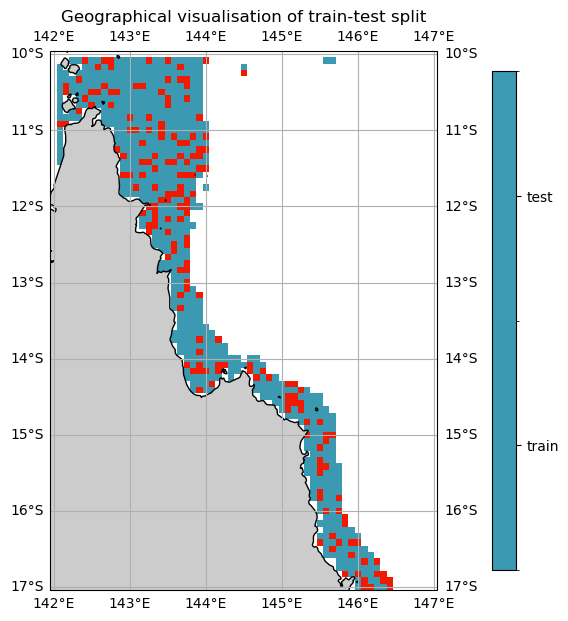

In [138]:
# X_train, X_test, y_train, y_test, train_coordinates,test_coordinates, xa_masked = spatial_split_train_test(
#     all_data, "gt", split_type="pixel", test_fraction = 0.2)

# test_train_da = visualise_train_test_split(all_data, train_coordinates, test_coordinates)
bath_mask = generate_var_mask(all_data)
test_xa = plot_train_test_spatial(test_train_da, bath_mask=bath_mask)


In [94]:
def n_random_runs_preds(model, runs_n, xa_ds, test_fraction: float=0.25, bath_mask: bool=True) -> list[tuple[list]]:
    """
    Perform multiple random test runs for inference using a model.

    Parameters
    ----------
        model: The model used for inference.
        runs_n: The number of random test runs.
        xa_ds: The xarray Dataset containing the data.
        test_fraction (optional): The fraction of data to use for testing. Defaults to 0.25.
        bath_mask (optional): Whether to apply a bathymetry mask during splitting. Defaults to True.

    Returns
    -------
        run_outcomes: A list of tuples containing the true labels and predicted values for each test run.
    """
    # TODO: allow spatial splitting, perhaps using **kwarg functionality to declare lat/lon limits
    # prediction_list = []
    run_outcomes = []
    for run in tqdm(range(runs_n), desc=f" Running inference on {runs_n} randomly-initialised test splits with {test_fraction} test fraction"):
        # randomly select test data
        _, X_test, _, y_test,_,_ = spatial_split_train_test(xa_ds, test_fraction=test_fraction, bath_mask=bath_mask)

        pred = model.predict(X_test)
        run_outcomes.append((y_test, pred))

    return run_outcomes


def rocs_n_runs(run_outcomes: tuple[list[float]], binarize_threshold: float=0, figsize=[7, 7]):
    """
    Plot ROC curves for multiple random test runs.

    Parameters
    ----------
        run_outcomes: A list of tuples containing the true labels and predicted values for each test run.
        binarize_threshold (optional): The threshold value for binarizing the labels. Defaults to 0.

    Returns
    -------
        None
    """
    color_map = spatial_plots.get_cbar("seq")
    num_colors = len(run_outcomes)
    colors = [color_map(i / num_colors) for i in range(num_colors)]

    f, ax = plt.subplots(figsize=figsize)
    for c, outcome in enumerate(run_outcomes):
        # cast regression to binary classification for plotting
        binary_y_labels, binary_predictions = model_results.threshold_label(outcome[0], outcome[1], binarize_threshold)

        fpr, tpr, _ = sklmetrics.roc_curve(binary_y_labels, binary_predictions, drop_intermediate=False)
        roc_auc = sklmetrics.auc(fpr, tpr)

        label = f"{roc_auc:.02f}"
        ax.plot(fpr, tpr, label=label, color=colors[c])

    n_runs = len(run_outcomes)
    # format
    format_roc(
        ax=ax, title=f"Receiver Operating Characteristic (ROC) Curve\n for {n_runs} randomly initialised test datasets.")

In [95]:
run_outcomes = n_random_runs_preds(rf_random, 10, all_data)

rocs_n_runs(run_outcomes)

NameError: name 'rf_random' is not defined

In [ ]:
def investigate_resolution_predictions(xa_ds: xa.DataArray):
    

In [218]:
out = np.mean(spatial_data.calculate_spatial_resolution(all_data))

In [219]:
1/out

12.171361502347418

In [207]:
def investigate_label_thresholds(
    thresholds: list[float],
    y_test: np.ndarray | pd.Series,
    y_predictions: np.ndarray | pd.Series,
    figsize=[7, 7],
):
    """
    Plot ROC curves with multiple lines for different label thresholds.

    Parameters
    ----------
        thresholds (list[float]): List of label thresholds.
        y_test (np.ndarray or pd.Series): True labels.
        y_predictions (np.ndarray or pd.Series): Predicted labels.
        figsize (list, optional): Figure size for the plot. Default is [7, 7].

    Returns
    -------
        None
    """
    # TODO: fix UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless

    f, ax = plt.subplots(figsize=figsize)
    # prepare colour assignment
    color_map = spatial_plots.get_cbar("seq")
    num_colors = len(thresholds)
    colors = [color_map(i / num_colors) for i in range(num_colors)]

    # plot ROC curves
    for c, thresh in enumerate(thresholds):
        binary_y_labels, binary_predictions = model_results.threshold_label(
            y_test, y_predictions, thresh
        )
        fpr, tpr, _ = sklmetrics.roc_curve(
            binary_y_labels, binary_predictions, drop_intermediate=False
        )
        roc_auc = sklmetrics.auc(fpr, tpr)

        label = f"{thresh:.01f} | {roc_auc:.02f}"
        ax.plot(fpr, tpr, label=label, color=colors[c])

    # format
    title = "Receiver Operating Characteristic (ROC) Curve\nfor several coral presence/absence thresholds"
    format_roc(ax=ax, title=title)
    ax.legend(title="threshold value | auc")


def format_roc(ax, title: str = "Receiver Operating Characteristic (ROC) Curve"):
    """
    Format the ROC plot axes.

    Args:
        ax: The matplotlib axes object.
        title (optional): The title of the ROC plot. Defaults to "Receiver Operating Characteristic (ROC) Curve".

    Returns:
        None
    """
    ax.set_title(title)
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_aspect("equal", "box")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])


    # plot "random" line for comparison (y=x)
    ax.plot([0, 1], [0, 1], color='gray', linestyle=(5,(10,3)))
    # Plot the grid
    ax.grid(color='lightgray', linestyle=':', linewidth=0.5)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))


In [159]:
rf_random_preds = rf_random.predict(X_test)

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


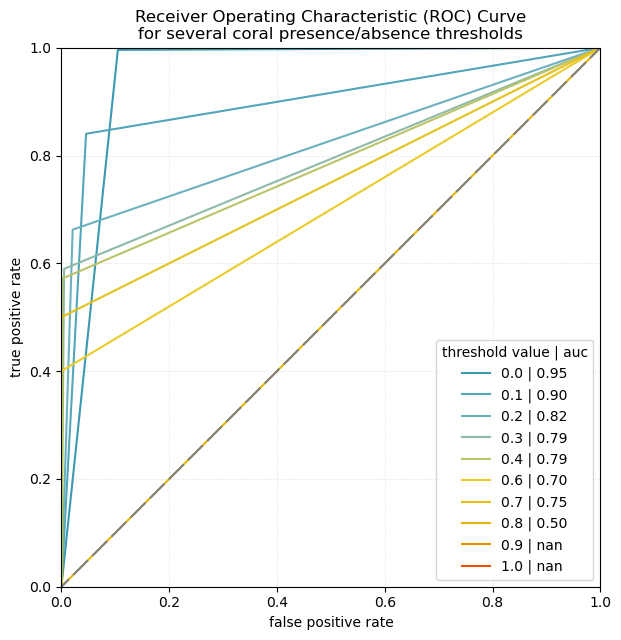

In [208]:
investigate_label_thresholds(np.linspace(0,1,10), y_test, rf_random_preds)

In [89]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [144]:
RANDOM_STATE = 42
rf_reg = RandomForestRegressor(random_state=RANDOM_STATE)
# rf_reg.get_params()
# rf_random = RandomizedSearchCV(
#     estimator = rf_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
#     random_state=RANDOM_STATE, n_jobs = -1)

rf_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [146]:
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [148]:
best_rf_params={"n_estimators":400,
"min_samples_split":2,
"min_samples_leaf":4,
"max_features":"sqrt",
"max_depth":10,
"bootstrap":True}

In [151]:
rf_random = rf_reg.set_params(**best_rf_params)

In [101]:
rf_random_search_best_params = rf_random.best_params_ 
# save best parameteers to json (in coralshift folder)
import json

with open("rf_random_search_best_params.json", "w") as fp:
    json.dump(rf_random_search_best_params, fp)

In [121]:
X_test

thetao_y_mean  thetao_annual_range   
latitude   longitude time                                             
-11.333333 142.0     1993-01-01      29.226082             8.586443  \
                     1994-01-01      27.384058             8.586443   
                     1995-01-01      27.972775             8.586443   
                     1996-01-01      28.147850             8.586443   
                     1997-01-01      27.396107             8.586443   
...                                        ...                  ...   
-10.000000 147.0     2016-01-01      28.396193             7.445293   
                     2017-01-01      27.954790             7.445293   
                     2018-01-01      27.523144             7.445293   
                     2019-01-01      27.303171             7.445293   
                     2020-01-01      28.005789             7.445293   

                                 thetao_m_min  thetao_m_max  thetao_m_std   
latitude   longitude time                                                   
-11.333333 142.0     1993-01-01     23.537188     32.123631      1.932281  \
                     1994-01-01     23.537188     32.123631      1.932281   
                     1995-01-01     23.537188     32.123631      1.932281   
                     1996-01-01     23.537188     32.123631      1.932281   
                     1997-01-01     23.537188     32.123631      1.932281   
...                                       ...           ...           ...   
-10.000000 147.0     2016-01-01     23.964935     31.410229      1.620939   
                     2017-01-01     23.964935     31.410229      1.620939   
                     2018-01-01     23.964935     31.410229      1.620939   
                     2019-01-01     23.964935     31.410229      1.620939   
                     2020-01-01     23.964935     31.410229      1.620939   

                                 thetao_w_min  thetao_w_max  salinity_y_mean   
latitude   longitude time                                                      
-11.333333 142.0     1993-01-01     23.537188     32.123631        35.393841  \
                     1994-01-01     23.537188     32.123631        35.089893   
                     1995-01-01     23.537188     32.123631        34.920921   
                     1996-01-01     23.537188     32.123631        34.699760   
                     1997-01-01     23.537188     32.123631        34.877117   
...                                       ...           ...              ...   
-10.000000 147.0     2016-01-01     23.964935     31.410229        34.865665   
                     2017-01-01     23.964935     31.410229        34.322037   
                     2018-01-01     23.964935     31.410229        34.560303   
                     2019-01-01     23.964935     31.410229        34.600536   
                     2020-01-01     23.964935     31.410229        34.557877   

                                 salinity_m_min  salinity_m_max   
latitude   longitude time                                         
-11.333333 142.0     1993-01-01       32.430492       36.069828  \
                     1994-01-01       32.430492       36.069828   
                     1995-01-01       32.430492       36.069828   
                     1996-01-01       32.430492       36.069828   
                     1997-01-01       32.430492       36.069828   
...                                         ...             ...   
-10.000000 147.0     2016-01-01       30.642109       35.566273   
                     2017-01-01       30.642109       35.566273   
                     2018-01-01       30.642109       35.566273   
                     2019-01-01       30.642109       35.566273   
                     2020-01-01       30.642109       35.566273   

                                 current_y_mean  current_m_min  current_m_max   
latitude   longitude time                                                       
-11.333333 142.0     1993-01-01 

In [156]:
# predictions = rf_random.predict(X_test)
# np.shape(predictions)
bce = log_loss(y_true=list(y_test), y_pred=predictions)

ValueError: Unknown label type: ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 1.1780864042520989e-05, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.019536523148417473, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.027411479502916336, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.04748502001166344, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.16425561904907227, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.30554112792015076, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.18837441504001617, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.37294602394104004, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.5582672357559204, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.319874107837677, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.03448045626282692, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.01954626850783825, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.029230602085590363, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.04579916596412659, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.16410788893699646, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.5158985257148743, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.10817936807870865, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.006634166929870844, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.08317834138870239, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.14496168494224548, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.09945597499608994, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.10225167870521545, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.30423468351364136, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.19958926737308502, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.3593697249889374, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.48548439145088196, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.3613772988319397, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.1235499158501625, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.035967711359262466, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.004379015415906906, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.008721726946532726, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.01579754240810871, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29263806343078613, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.29062792658805847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.0008111682836897671, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.003096949076279998, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.007901146076619625, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.15402625501155853, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.26963430643081665, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.23467311263084412, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.3204439580440521, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.23135969042778015, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.38713523745536804, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.2886452078819275, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.0975220650434494, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.018684977665543556, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.0037456871941685677, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.01010901015251875, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.009951528161764145, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.17135223746299744, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.2759687006473541, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.038137536495923996, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.028169898316264153, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.00015724252443760633, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.0559561550617218, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.23260413110256195, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.06590013951063156, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.22044557332992554, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.43133631348609924, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.3150147497653961, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.37820345163345337, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.09597691893577576, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0018740530358627439, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0007224207511171699, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.0030022438149899244, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.29221951961517334, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.2301393300294876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.0014077603118494153, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.009432259947061539, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.03943629935383797, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.003098822198808193, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.0026727779768407345, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.04331257939338684, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.08199901133775711, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.07940328121185303, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.19612787663936615, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.24138899147510529, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.27677521109580994, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.37821441888809204, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.12229283899068832, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.006268078461289406, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.015237809158861637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.01121484488248825, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.44975122809410095, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.1580464094877243, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.04199178144335747, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.01256467867642641, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.0018050684593617916, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.06353900581598282, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 0.007232632953673601, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 4.117410207982175e-05, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.032088153064250946, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.07150907069444656, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.0983952209353447, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.027954936027526855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.0220864899456501, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.13822250068187714, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.21351258456707, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.2479432076215744, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.20437398552894592, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.24694374203681946, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.15336152911186218, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.03269485384225845, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.04344375804066658, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.01598530262708664, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.007141965441405773, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.42697370052337646, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.12260322272777557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.07302585989236832, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.01895352266728878, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.015139872208237648, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.007794196717441082, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.08745218068361282, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.024385672062635422, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.010138588026165962, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.0982619896531105, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.086349718272686, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.35765039920806885, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.04674588888883591, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.03879057988524437, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.05830664560198784, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.049178775399923325, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.03652389347553253, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.09291292726993561, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.26357993483543396, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.208064004778862, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.21173684298992157, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.19402919709682465, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.13762255012989044, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.08245629072189331, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.09448778629302979, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.031200025230646133, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.44271185994148254, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.05317419022321701, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.051882874220609665, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.12104933708906174, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.11054566502571106, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.15874367952346802, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.18030217289924622, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.014962648041546345, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1722935289144516, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.1407860368490219, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.3227634131908417, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.05431563779711723, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.021013902500271797, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.037229664623737335, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.1456625759601593, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.11500871926546097, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.06133685261011124, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.26143112778663635, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.19192788004875183, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.1595247983932495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.17243461310863495, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.19875402748584747, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.11863332241773605, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.03714212030172348, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.1423453390598297, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.4363704025745392, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.007545845117419958, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.08500426262617111, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.06331922113895416, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.09346448630094528, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.14493870735168457, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.054141998291015625, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.011616339907050133, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.098700150847435, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.24604079127311707, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.42589667439460754, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.4011967182159424, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.19767513871192932, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.07719708234071732, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.06764346361160278, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.08380153775215149, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.15934669971466064, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.10700984299182892, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.20519720017910004, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.13352058827877045, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.12683722376823425, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.11772766709327698, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.05564635992050171, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.03181711956858635, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.38690048456192017, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 0.26776811480522156, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 5.78793442400638e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.037033483386039734, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.32195526361465454, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.33799535036087036, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.23802700638771057, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.014244393445551395, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.06661450862884521, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.11215223371982574, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.0056663514114916325, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.13544227182865143, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.4110961854457855, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.05227407068014145, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.16277022659778595, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.047874871641397476, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.14664828777313232, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.15202797949314117, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.2675899565219879, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.16943196952342987, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.10875926911830902, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.12281429767608643, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.07580816000699997, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.06379164010286331, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.5792371034622192, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0739373192191124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.06585204601287842, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.5318161249160767, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.41233599185943604, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.15786752104759216, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.046954311430454254, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.018321633338928223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.004063189961016178, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 0.012400705367326736, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 7.144955452531576e-05, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0874348133802414, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.0461854413151741, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.15128637850284576, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.18720632791519165, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.24758058786392212, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.21146634221076965, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.06691648811101913, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.1964612752199173, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.10926087945699692, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.07482902705669403, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.5727789402008057, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.05020176246762276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.00029146409360691905, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.05109135061502457, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.025097087025642395, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.01752263680100441, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.14148016273975372, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.5722649097442627, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.3818134069442749, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.018220098689198494, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.023782191798090935, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.007830977439880371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 6.84457108945935e-06, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.0029353066347539425, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.00024540998856537044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.006982635241001844, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.018162395805120468, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.1512780785560608, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.16494043171405792, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.12436273694038391, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.32420188188552856, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.34326696395874023, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.22813579440116882, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.03172948583960533, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.027873201295733452, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.5655151009559631, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.11625931411981583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.042038653045892715, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.24497461318969727, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.2199072539806366, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.04057213291525841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.05917289853096008, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.3780052065849304, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.5121276378631592, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.4651030898094177, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.14160506427288055, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.009723689407110214, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.004302913323044777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.0011180241126567125, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.08178149908781052, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.006915617268532515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.019978204742074013, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.015398458577692509, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.1177314966917038, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.17185938358306885, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.20079229772090912, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.11824958026409149, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.21253308653831482, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.35890811681747437, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.1173735186457634, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.02262849174439907, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.44197776913642883, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.1439998298883438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.05717451497912407, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1253708004951477, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.1486682891845703, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.11218466609716415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.004112261347472668, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.021976413205266, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.10456109046936035, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.5668393969535828, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.6308841109275818, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.39707279205322266, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.17311033606529236, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.02591751702129841, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.11569499224424362, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0043432703241705894, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.0014315748121589422, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.01198914460837841, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.22118031978607178, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.039193201810121536, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.00026821039500646293, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.04309114068746567, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.02236744575202465, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.009952742606401443, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.11761274188756943, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.08766057342290878, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.33303627371788025, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.3290243446826935, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.2564837634563446, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.22054633498191833, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.08591051399707794, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2877929210662842, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.2527552545070648, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.00037081289337947965, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.01504641305655241, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.1593174785375595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.07212041318416595, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.21958930790424347, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.017390534281730652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.006978165358304977, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.05814029276371002, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.14453837275505066, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.011092105880379677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.013794266618788242, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.14206744730472565, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.3850754201412201, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.1971183568239212, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.21039247512817383, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.011883584782481194, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.12163518369197845, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.020246597006917, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.03811940550804138, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.0238557867705822, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2963319420814514, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.2706409692764282, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.030614294111728668, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.02760385535657406, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.029744870960712433, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.0578058622777462, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.11141795665025711, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.10770979523658752, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.13716302812099457, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.2172551304101944, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.6418547034263611, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.4236317574977875, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.2818288803100586, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.18664099276065826, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.4239286780357361, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.029359441250562668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.002497794572263956, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.13928930461406708, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.058041173964738846, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.22638365626335144, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.025500858202576637, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0032544280402362347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.0432867631316185, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.2742258608341217, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.20430712401866913, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.1453857570886612, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.00042288904660381377, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.012905169278383255, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.24612896144390106, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.2628622055053711, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.15768781304359436, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.09243763983249664, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.023947279900312424, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.029398303478956223, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.0007340272422879934, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.00032454871688969433, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.006222109775990248, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.1939823180437088, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.21408462524414062, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.05781475827097893, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.15190663933753967, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.09768570214509964, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.017771830782294273, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.15991222858428955, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.10657208412885666, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.49063679575920105, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.682346761226654, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7288316488265991, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7176417112350464, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.7800965309143066, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.3035987317562103, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.23483635485172272, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.21583528816699982, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.002827616408467293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.0446108840405941, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.19065475463867188, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.11458150297403336, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.07076062262058258, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.034306950867176056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.0014823361998423934, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.023608410730957985, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.24185043573379517, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.15507188439369202, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.2463218718767166, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.03972141817212105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.019172918051481247, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.31920868158340454, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.44191497564315796, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.13794584572315216, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.00027549927472136915, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.023357009515166283, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.01963357999920845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.0034061626065522432, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.32551342248916626, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.416587233543396, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.1285048872232437, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.13995535671710968, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.04185403883457184, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0015916383126750588, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.0006824921001680195, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.28690505027770996, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.6006884574890137, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.623262882232666, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.30928996205329895, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.29631301760673523, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.827182412147522, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.39206647872924805, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.24117322266101837, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.3719262182712555, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.036560166627168655, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.0017351644346490502, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.04111531004309654, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.011412947438657284, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.1493414342403412, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.09100749343633652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.022089170292019844, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.15420883893966675, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.25894200801849365, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.3798227310180664, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.34573304653167725, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.053132981061935425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)

In [180]:
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import metrics
# predictions = rf_random.predict(X_test)

mean_squared_error(y_test,predictions)

0.029008365628501703

In [173]:
# predictions = rf_reg.predict(X_test)
# predictions
sum(y_test.where(y_test <= 0,1))

12068.0

In [187]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [224]:
val = 0
for i in range(11):
    print(val, sum(y_test.where(y_test >= val, 1)))
    val += 0.1

0 1824.1129899465068
0.1 24501.692299455404
0.2 26749.8374235034
0.30000000000000004 27975.966237306595
0.4 28577.76510286331
0.5 28845.810957431793
0.6 28958.51809811592
0.7 29009.505064487457
0.7999999999999999 29031.16110754013
0.8999999999999999 29036.0
0.9999999999999999 29036.0


In [230]:
out = np.array(y_test)
sum(np.where(out > 0.1, 1, 0))

6160

In [274]:

    

rf_reg_preds = rf_reg.predict(X_test)
rf_random_preds = rf_random.predict(X_test)

In [269]:
np.where(sum(np.array(y_test)) > 0.1, 1, 0)

True

In [140]:
# TODO: function to do N model runs and plot resultant ROC
# TODO: test whether training/optimising on binary helps


model_results.investigate_label_thresholds(np.linspace(0,1,100), y_test, rf_reg_preds)


NameError: name 'model_results' is not defined

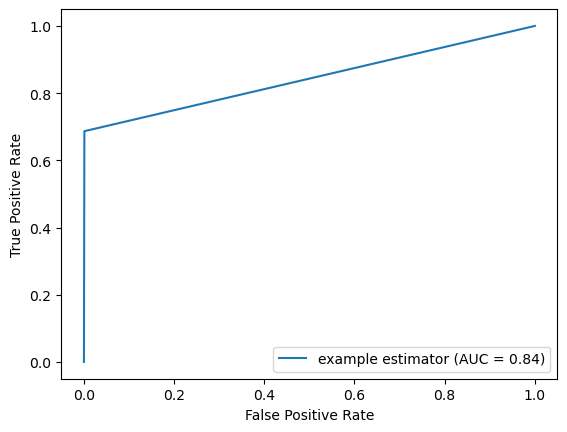

In [257]:
fpr, tpr, thresholds = metrics.roc_curve(y_labels_bin, predictions_bin, drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='example estimator')
display.plot()

### Maximum Entropy Model

In [30]:
from sklearn import preprocessing

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(target_df)

In [31]:
# maxent = LogisticRegression(random_state=0)
# maxent.fit(features_df, y_transformed)

In [32]:
# pred_maxent = maxent.predict(features_df)

# predicted_maxent_data = xa.DataArray(pred_maxent.reshape((85,61,28)),
#     coords=all_data.coords, 
#     dims=all_data.dims)

# f,a = plt.subplots(1,2,figsize=[14,7])
# all_data["gt"].plot(ax=a[0])
# predicted_maxent_data.isel(time=-1).plot(ax=a[1]
#     , vmin=all_data["gt"].values.min(), vmax=all_data["gt"].values.max()
#     )

### Classification and Regression Trees (CART)

In [72]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
clf = RandomForestRegressor()
clf_lim = RandomForestRegressor()

num_vals = 50000
clf.fit(features_df, target_df)
clf_lim.fit(features_df[:num_vals], target_df[:num_vals])
pred_lim = clf_lim.predict(features_df)

In [82]:
# clf.fit(features_df, target_df)
pred = clf.predict(features_df)
predicted_data = xa.DataArray(pred.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)

predicted_lim_data = xa.DataArray(pred_lim.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)

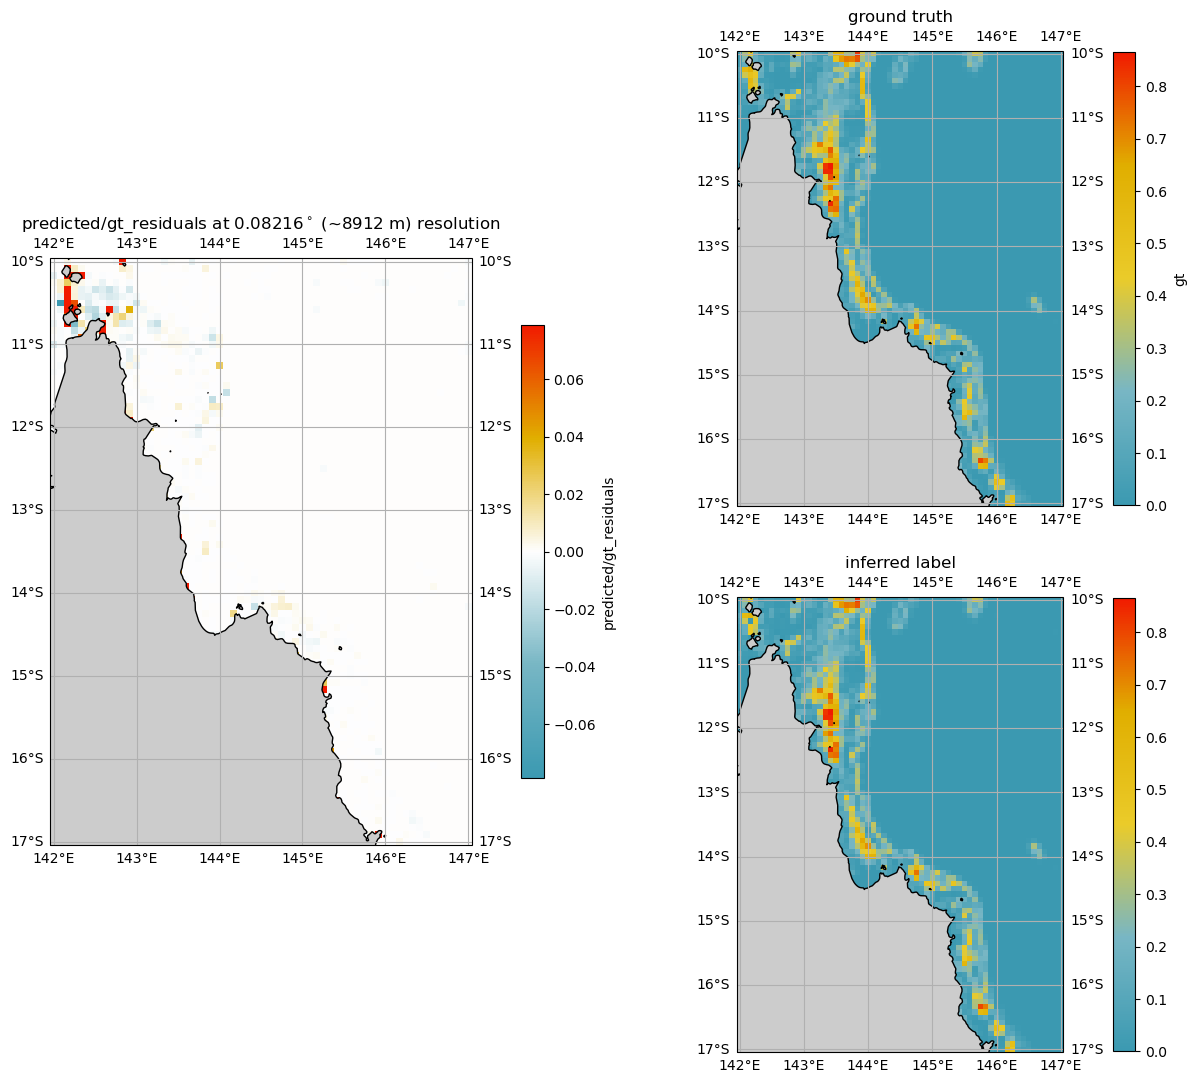

In [74]:
### Compare predicted and ground truth values
spatial_plots.plot_spatial_diffs(predicted_data, gt_climate_res, figsize=(14,13))


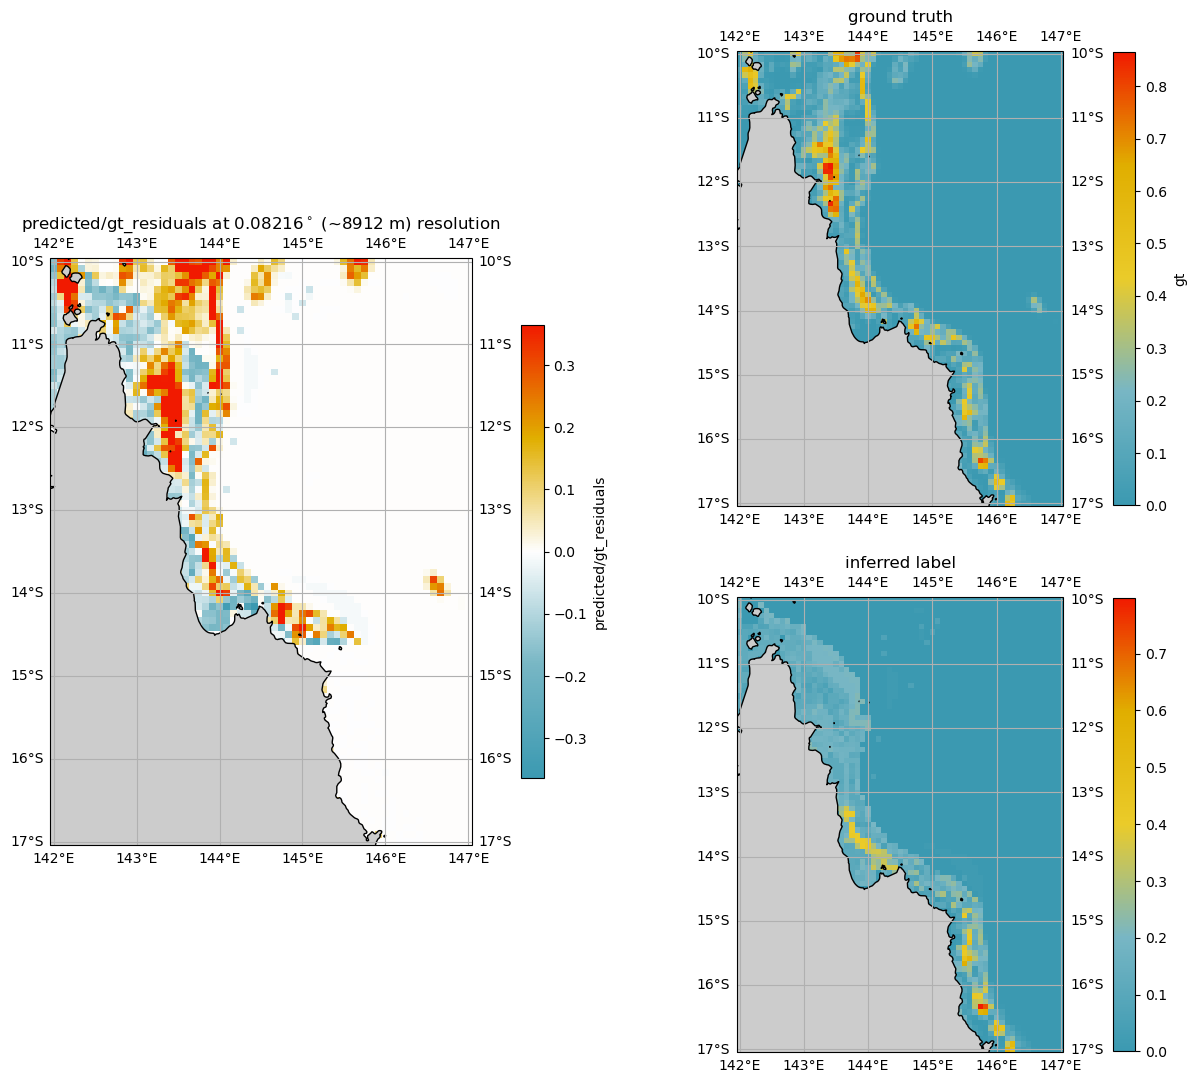

In [83]:
spatial_plots.plot_spatial_diffs(predicted_lim_data, gt_climate_res, figsize=(14,13))

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle




def train_test_random_forest(xa_ds: xa.Dataset, target_variable: str = "gt", test_fraction=0.5, random_state=None):
    # TODO: tidy up and document
    # Extract latitude, longitude, and time values from the spatial image
    lats = xa_ds.latitude.values
    lons = xa_ds.longitude.values
    times = xa_ds.time.values


    if len(xa_ds.dims) > 2:
        # Flatten the spatial image into 2D arrays for training and testing
        flattened_data = xa_ds.stack(points=("latitude", "longitude", "time")).compute().to_dataframe().fillna(0).drop(
            ["time","spatial_ref","band","depth"], axis=1).astype("float32")
    else:
        flattened_data = xa_ds.stack(points=("latitude", "longitude")).compute().to_dataframe().fillna(0).drop(
            ["time","spatial_ref","band","depth"], axis=1).astype("float32")

    features = flattened_data.drop("gt", axis=1)
    # flattened_data = np.transpose(flattened_data, axes=(1, 0))
    labels = flattened_data["gt"]

    # # Split the data into training and testing datasets
    # X_train, X_test, y_train, y_test = train_test_split(
    #     features, labels, test_size=test_fraction, random_state=random_state
    # )

    # Train the random forest regressor
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    # Predict the target variable for the testing dataset
    y_pred = regressor.predict(X_test)

    train_indices = X_train.index.values
    test_indices = X_test.index.values

    lat_spacing = xa_ds.latitude.values[1] - xa_ds.latitude.values[0]
    lon_spacing = xa_ds.longitude.values[1] - xa_ds.longitude.values[0]

    # TODO: refer to generic data_var dimension rather than calling by variable
    train_pixs = np.empty(xa_ds["thetao_y_mean"].values.shape)
    train_pixs[:] = np.nan
    test_pixs = np.empty(xa_ds["thetao_y_mean"].values.shape)
    test_pixs[:] = np.nan
    # Color the spatial pixels corresponding to training and testing regions
    for train_index in tqdm(train_indices, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, train_index[0], train_index[1], lat_spacing, lon_spacing)
        # ax.add_patch(Rectangle((lons[col], lats[row]), 1, 1, facecolor=train_color, alpha=0.2))
        train_pixs[row,col] = 0

    for test_index in tqdm(test_indices, desc="Coloring in training indices..."):
        row, col = find_index_pair(xa_ds, test_index[0], test_index[1], lat_spacing, lon_spacing)
        # ax.add_patch(Rectangle((lons[col], lats[row]), 1, 1, facecolor=test_color, alpha=0.2))
        test_pixs[row,col] = 1


    # ds = xa.Dataset(
    # {
    #     'test_train': (xa_ds.dims, np.nansum(np.stack((test_pixs,train_pixs)), axis=0)),
    # },
    # coords=xa_image.coords)

    return regressor, y_pred, ds


def find_index_pair(data_array, lat, lon, lat_spacing, lon_spacing):
    # Get the latitude and longitude spacing

    lat_values = list(data_array.latitude.values)
    lon_values = list(data_array.longitude.values)

    lat_index = np.where(np.isclose(lat_values, lat))[0][0]
    lon_index = np.where(np.isclose(lon_values, lon))[0][0]

    return lat_index, lon_index

reg,random_pred,ds = train_test_random_forest(all_data.isel(time=0), target_variable=all_data["gt"], random_state=42)

Coloring in training indices...: 100%|██████████| 14518/14518 [00:05<00:00, 2651.40it/s]


NameError: name 'ds' is not defined

In [ ]:
random_pred_data = xa.DataArray(random_pred.reshape((85,61,28)),
    coords=all_data.coords,
    dims=all_data.dims)


spatial_plots.plot_spatial_diffs(random_pred_data, gt_climate_res, figsize=(14,13))



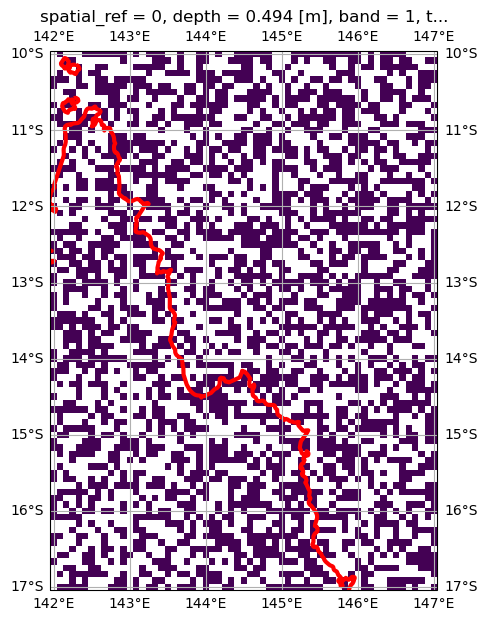

In [484]:
def plot_train_test_spatial(dataset, figsize: tuple[float,float] = (7,7)):
    """
    Plot two spatial variables from a dataset with different colors and labels.

    Parameters:
    dataset (xarray.Dataset): The dataset containing the variables.

    Returns:
    None
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize = figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Plot variable1 with color and label
    dataset["train_pixs"].plot(ax=ax, vmin=0, vmax=1, levels=2, label="train_pixs",add_colorbar=False)

    # Plot variable2 with color and label
    dataset["test_pixs"].plot(ax=ax, vmin=0, vmax=1, levels=2, label="test_pixs", add_colorbar=False)
    ax.set_aspect("equal")
    ax.coastlines(resolution="10m", color="red", linewidth=3)
    # Add a colorbar for each variable
    # cbar1 = plt.colorbar(ax=ax, mappable=dataset["train_pixs"])
    # cbar2 = plt.colorbar(ax=ax, mappable=dataset["test_pixs"])
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)




plot_train_test_spatial(ds)




/tmp/ipykernel_17620/2730091325.py:36: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


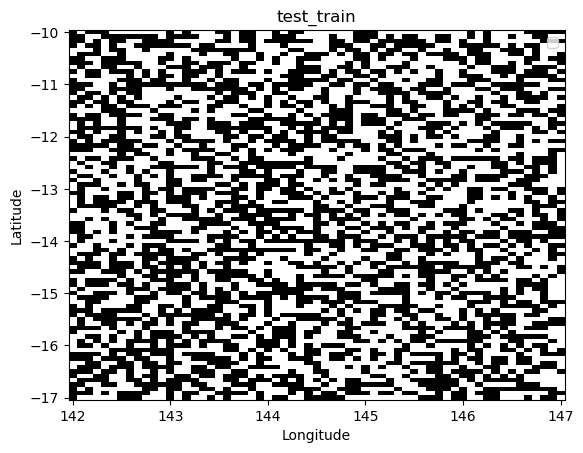

In [503]:


def plot_categorical_data(dataset, variable_name,  color1='red', color2='blue'):
    """
    Plot categorical spatial data from an xarray dataset.

    Parameters:
    dataset (xarray.Dataset): The dataset containing the categorical data.
    variable_name (str): The name of the variable in the dataset to plot.

    Returns:
    None
    """
    # Extract the required data variable
    variable = dataset[variable_name]

    # Get the latitude, longitude, and values arrays
    latitudes = variable.latitude.values
    longitudes = variable.longitude.values
    values = variable.values

    # Create a meshgrid from latitude and longitude arrays
    lon_mesh, lat_mesh = np.meshgrid(longitudes, latitudes)

    # Plot the categorical data
    mask1 = values == 0
    mask2 = values == 1

    # Plot the binary categorical data
    plt.pcolormesh(lon_mesh, lat_mesh, mask1, cmap='Greys', facecolor=color1)
    plt.pcolormesh(lon_mesh, lat_mesh, mask2, cmap='Greys', facecolor=color2)

    # Add colorbar and labels
    # plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(variable_name)
    plt.legend()
    # Show the plot
    plt.show()

plot_categorical_data(ds,"test_train")


In [495]:
ds

<xarray.Dataset>
Dimensions:      (latitude: 85, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * longitude    (longitude) float32 142.0 142.1 142.2 ... 146.8 146.9 147.0
    spatial_ref  int64 0
    depth        float32 0.494
    band         int64 1
    time         datetime64[ns] 1993-01-01
Data variables:
    test_train   (latitude, longitude) float64 nan nan nan nan ... nan nan nan

In [337]:
all_data

<xarray.Dataset>
Dimensions:              (latitude: 85, longitude: 61, time: 28)
Coordinates:
  * latitude             (latitude) float32 -17.0 -16.92 -16.83 ... -10.08 -10.0
  * longitude            (longitude) float32 142.0 142.1 142.2 ... 146.9 147.0
  * time                 (time) datetime64[ns] 1993-01-01 ... 2020-01-01
    spatial_ref          int64 0
    depth                float32 0.494
    band                 int64 1
Data variables: (12/14)
    thetao_y_mean        (latitude, longitude, time) float64 nan nan ... 28.01
    thetao_annual_range  (latitude, longitude) float32 nan nan ... 7.472 7.445
    thetao_m_min         (latitude, longitude) float32 nan nan ... 23.89 23.96
    thetao_m_max         (latitude, longitude) float32 nan nan ... 31.37 31.41
    thetao_m_std         (latitude, longitude) float64 nan nan ... 1.596 1.621
    thetao_w_min         (latitude, longitude) float32 nan nan ... 23.89 23.96
    ...                   ...
    salinity_m_min       (latitude, longitude) float32 nan nan ... 30.44 30.64
    salinity_m_max       (latitude, longitude) float32 nan nan ... 35.56 35.57
    current_y_mean       (latitude, longitude, time) float64 nan nan ... 0.367
    current_m_min        (latitude, longitude) float32 nan nan ... 0.002441
    current_m_max        (latitude, longitude) float32 nan nan ... 1.143 1.095
    gt                   (latitude, longitude) float64 dask.array<chunksize=(85, 61), meta=np.ndarray>

In [ ]:


predicted_lim_data = xa.DataArray(pred_lim.reshape((85,61,28)),
    # coords=all_data.coords, 
    dims=all_data.dims)

f,a = plt.subplots(1,2,figsize=[14,7])
predicted_data.isel(time=0).plot(ax=a[0])
predicted_lim_data.isel(time=0).plot(ax=a[1], vmin=predicted_data.min(), vmax=predicted_data.max())

In [ ]:
# TODO: training and testing on subsamples of data (train_test_split for linear, somehow something spatial...)
# add in bathymetry
# try binary (classifier)
# function to plot difference between predicted and true
# hyperparameter tuning

### Boosted Regression Trees (BRT)

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [109]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    features_df, target_df, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [110]:
X_train_t

,,,thetao_y_mean,thetao_annual_range,thetao_m_min,thetao_m_max,thetao_m_std,thetao_w_min,thetao_w_max,salinity_y_mean,salinity_m_min,salinity_m_max,current_y_mean,current_m_min,current_m_max
latitude,longitude,time,,,,,,,,,,,,,
-16.416666,146.166672,2019-01-01,26.576600,8.242195,22.886776,31.128971,1.782261,22.886776,31.128971,34.874419,33.693962,35.607471,0.313649,0.005251,1.104791
-16.250000,144.666672,2002-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-11.583333,142.250000,2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-11.833333,145.916672,2003-01-01,27.503438,6.890104,24.211035,31.101139,1.499306,24.211035,31.101139,35.200195,32.651752,35.647144,0.180295,0.004316,1.063456
-14.083333,142.500000,1996-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-10.000000,145.416672,2001-01-01,27.457402,7.090794,24.127537,31.218330,1.457576,24.127537,31.218330,34.785360,32.589191,35.639515,0.250929,0.002730,0.913581
-14.166667,142.500000,2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-13.083333,146.750000,2012-01-01,27.483102,7.087132,24.016205,31.103336,1.534480,24.016205,31.103336,34.704808,33.089695,35.822628,0.241391,0.003052,0.788033


In [76]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0028


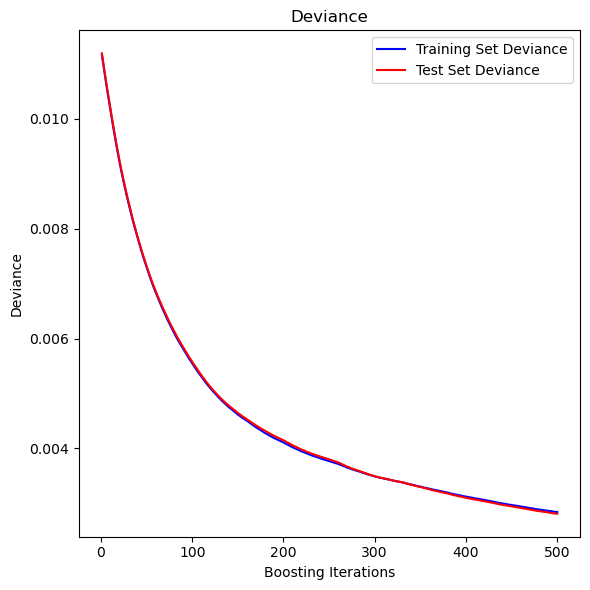

In [77]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

11884.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11885.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11885.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/debugpy/_vendored/force_pydevd.py:18: UserWarning: incompatible copy of pydevd already imported:
 /lustre_scratch/orlando-code/conda-envs/coralshift/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/__init__.py
  /lustre_scratch/orlando-code/conda-envs/coralshift/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_calltip_util.py
  /lustre_scratch/orlando-code/conda-envs/coralshift/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_completer.py
  /lustre_scratch/orlando-code/conda-envs/coralshift/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundl

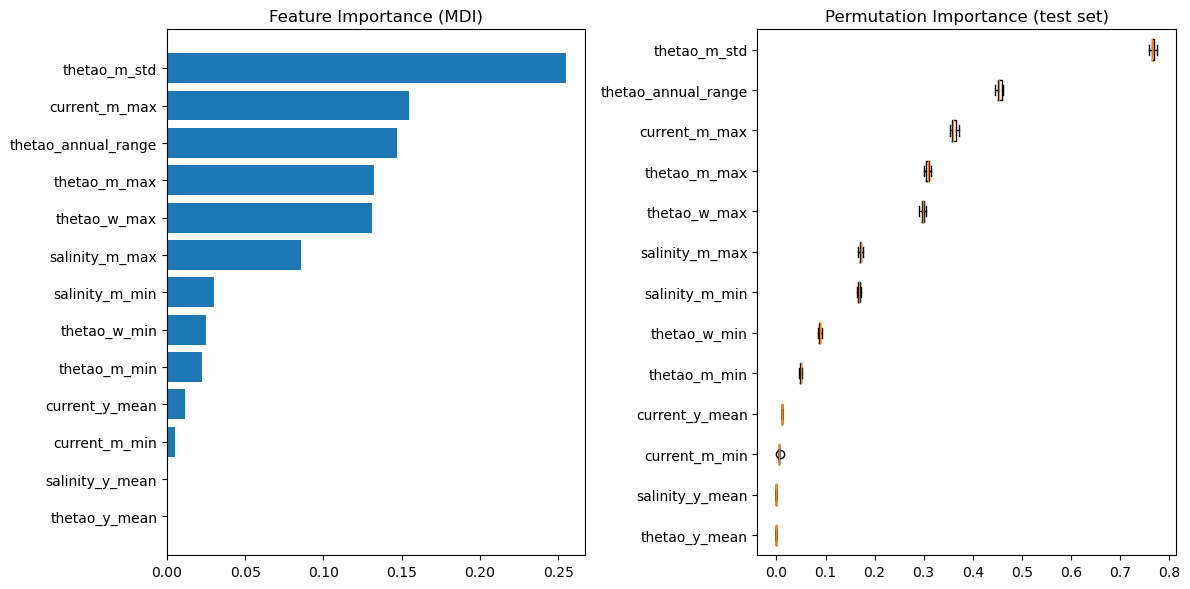

In [78]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_df.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_df.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [79]:
gbr_pred = reg.predict(features_df)

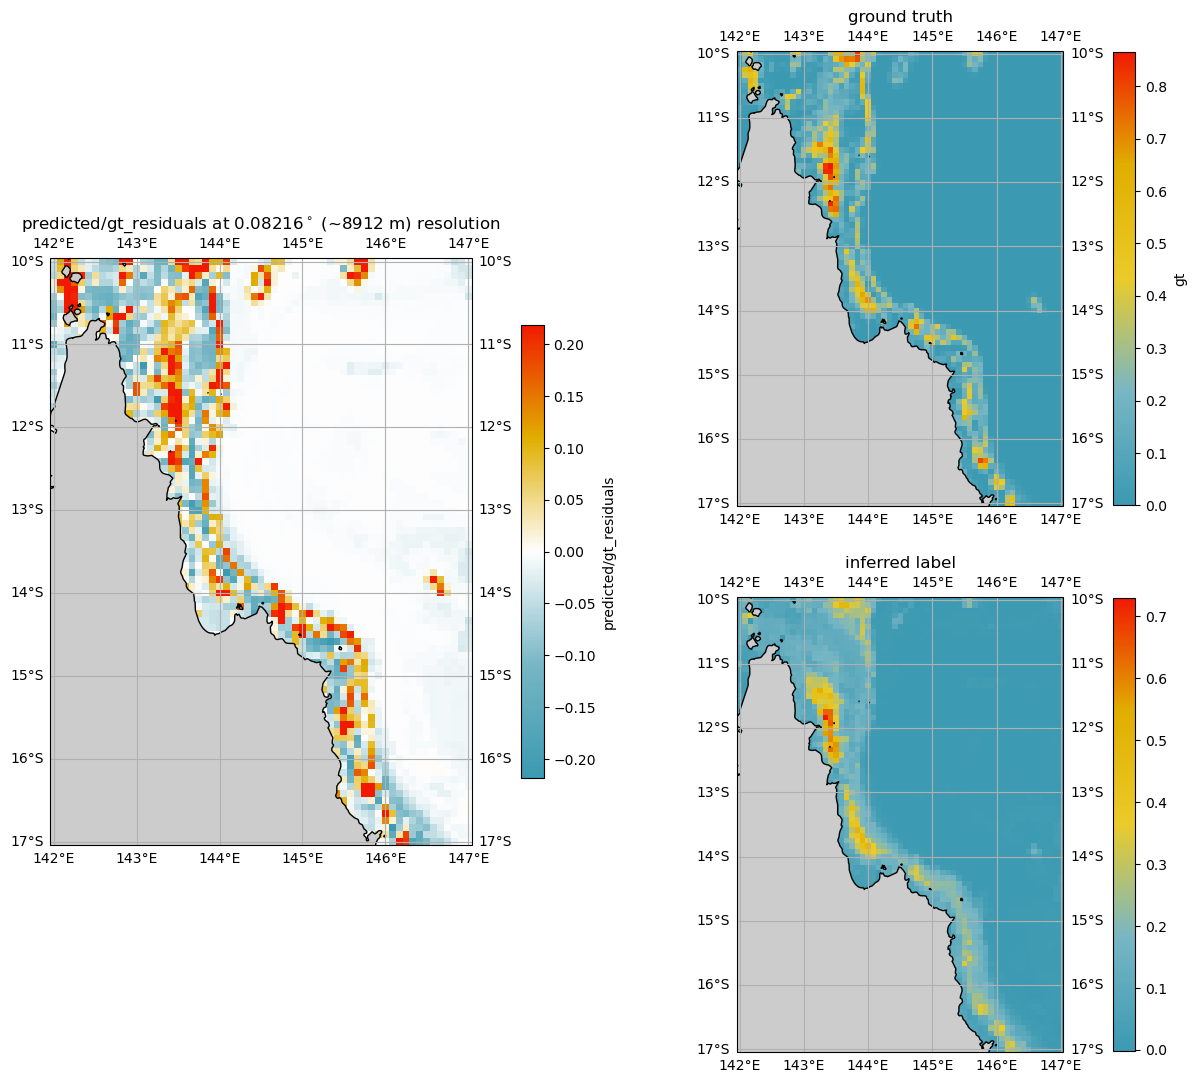

In [90]:

predicted_gbr_data = xa.DataArray(gbr_pred.reshape((85,61,28)),
    coords=all_data.coords, 
    dims=all_data.dims).isel(time=0)


spatial_plots.plot_spatial_diffs(predicted_gbr_data, gt_climate_res, figsize=(14,13))



# f,a = plt.subplots(1,2,figsize=[14,7])
# all_data["gt"].plot(ax=a[0])
# predicted_gbr_data.isel(time=-1).plot(ax=a[1]
#     , vmin=all_data["gt"].values.min(), vmax=all_data["gt"].values.max()
#     )